In [1]:
import jupyter_addons as ja
ja.set_css()

## Network Design with PypeFlow API - Example 3 
# Adding Balancing Valves & Control Valves to a Closed Network

## 1. Setting up the `Designer`

We will continue to work with the network from the design examples 1 and 2, but now we have modified it into a closed network. Look at the scheme [here](../resources/ex3_scheme.pdf). In the cross-overs of the riser we have added a balancing valve and a control valve. The csv network configuration file now looks as shown below. It describes the pipe sections in the network without any fittings, balancing valves or control valves.

In [2]:
import pandas as pd

df = pd.read_csv('../projects/config2_bal_pressure.csv')
ja.display_table(df)

,section_id,start_node_id,start_node_height,end_node_id,end_node_height,length,diameter_nom,flow_rate,pressure_drop
0,s12,n1,0.0,n2,4.4,16.7,40,1.696,NaN
1,s23,n2,4.4,n3,7.1,2.7,40,1.484,NaN
2,s34,n3,7.1,n4,9.8,2.7,40,1.272,NaN
3,s45,n4,9.8,n5,12.5,2.7,40,1.060,NaN
4,s56,n5,12.5,n6,15.2,2.7,40,0.848,NaN
5,s67,n6,15.2,n7,17.9,2.7,40,0.636,NaN
6,s78,n7,17.9,n8,20.6,2.7,40,0.424,NaN
7,s89,n8,20.6,n9,23.3,2.7,40,0.212,NaN
8,s22*,n2,4.4,n2*,4.4,10.0,20,0.212,NaN
9,s33*,n3,7.1,n3*,7.1,10.0,20,0.212,NaN


In row 8 up to and including row 15 of the network configuration the cross-overs are added to the network configuration. These sections have a nominal diameter (DN) of 20 mm. We also modified the flow rates in the sections. Each cross-over has an equal flow rate of 0.212 L/s. The flow rates in the pipe sections of the riser follow from the law of continuity applied to the nodes.

We start by setting up the `Designer` like we did in design example 2:

In [3]:
from pypeflow.design import Designer

Designer.set_units({
    'length': 'm',
    'diameter': 'mm',
    'flow_rate': 'L/s',
    'pressure': 'bar',
    'velocity': 'm/s'
})

Designer.create_network(
    start_node_id='n1',
    end_node_id='n0',
    fluid='water',
    fluid_temperature=10.0,
    pipe_schedule='pipe_schedule_40'
)

Designer.configure_network('../projects/config2_bal_pressure.csv')

Unlike the previous example, we haven't add any fittings in this case. Let's have a look already at the flow paths in the network:

In [4]:
df_paths = Designer.get_paths()
ja.display_table(df_paths)

,path,"dp,vel [bar]","dp,elev [bar]","dp,dyn [bar]","dp,stat req. [bar]","dp,dif [bar]"
1,s12|s22*|s2*0,0.0,0.0,0.199,0.199,0.064
2,s12|s23|s33*|s3*2*|s2*0,0.0,0.0,0.220,0.220,0.043
3,s12|s23|s34|s44*|s4*3*|s3*2*|s2*0,0.0,0.0,0.236,0.236,0.027
4,s12|s23|s34|s45|s55*|s5*4*|s4*3*|s3*2*|s2*0,0.0,0.0,0.247,0.247,0.015
5,s12|s23|s34|s45|s56|s66*|s6*5*|s5*4*|s4*3*|s3*2*|s2*0,0.0,0.0,0.255,0.255,0.007
6,s12|s23|s34|s45|s56|s67|s77*|s7*6*|s6*5*|s5*4*|s4*3*|s3*2*|s2*0,0.0,0.0,0.260,0.260,0.003
7,s12|s23|s34|s45|s56|s67|s78|s88*|s8*7*|s7*6*|s6*5*|s5*4*|s4*3*|s3*2*|s2*0,0.0,0.0,0.262,0.262,0.001
0,s12|s23|s34|s45|s56|s67|s78|s89|s99*|s9*8*|s8*7*|s7*6*|s6*5*|s5*4*|s4*3*|s3*2*|s2*0,0.0,0.0,0.263,0.263,0.000


Notice that the velocity head and elevation head will always be zero in a closed network.

## 2. Adding Balancing Valves to the Cross-overs

Make a list with the ids of the cross-over sections in which the balancing valves and control valves will be inserted:

In [5]:
cross_overs = ['s22*', 's33*', 's44*', 's55*', 's66*', 's77*', 's88*', 's99*']

### 2.1 Determining Preliminary Kvs-values of the Balancing Valves

For each balancing valve we set a design pressure drop across the fully open balancing valve. The value of the design pressure drop must be expressed in the measuring units that were passed to the `Designer` when setting it up (see step 1 above). When the balancing valves are added to the network, the `Designer` will calculate a preliminary Kvs-value for each balancing valve, based on the given design pressure drop. Take a look at the API documentation to see how to use the `Designer`'s method `add_balancing_valves` in the module `pypeflow.design.design`.

In [6]:
import quantities as qty

dp_design = qty.Pressure(3.0, 'kPa') 

Kvs_pre_list = Designer.add_balancing_valves([(cross_over, dp_design('bar')) for cross_over in cross_overs])

d = {
    'section id': [t[0] for t in Kvs_pre_list],
    'preliminary Kvs': [round(t[1], 3) for t in Kvs_pre_list]
}
df_bal_preKvs = pd.DataFrame(d)
ja.display_table(df_bal_preKvs)    

,section id,preliminary Kvs
0,s22*,4.408
1,s33*,4.408
2,s44*,4.408
3,s55*,4.408
4,s66*,4.408
5,s77*,4.408
6,s88*,4.408
7,s99*,4.408


In order to obtain the chosen design pressure drop across the balancing valve, we should select a balancing valve with a Kvs-value of 4.4.

### 2.2 Selecting Commercially Available Balancing Valves

Based on the preliminary Kvs-values and the nominal diameters of the cross-overs we can search for a commercially available balancing valve. In a catalogue we find a balancing valve DN20 with a Kvs-value of 6.5. We will initialize the balancing valves with this value:

In [7]:
Designer.init_balancing_valves([(cross_over, 6.5) for cross_over in cross_overs])

Let's take a look again at the flow paths in the network after inserting the balancing valves:

In [8]:
df_paths = Designer.get_paths()
ja.display_table(df_paths)

,path,"dp,vel [bar]","dp,elev [bar]","dp,dyn [bar]","dp,stat req. [bar]","dp,dif [bar]"
1,s12|s22*|s2*0,0.0,0.0,0.213,0.213,0.064
2,s12|s23|s33*|s3*2*|s2*0,0.0,0.0,0.234,0.234,0.043
3,s12|s23|s34|s44*|s4*3*|s3*2*|s2*0,0.0,0.0,0.250,0.250,0.027
4,s12|s23|s34|s45|s55*|s5*4*|s4*3*|s3*2*|s2*0,0.0,0.0,0.261,0.261,0.015
5,s12|s23|s34|s45|s56|s66*|s6*5*|s5*4*|s4*3*|s3*2*|s2*0,0.0,0.0,0.269,0.269,0.007
6,s12|s23|s34|s45|s56|s67|s77*|s7*6*|s6*5*|s5*4*|s4*3*|s3*2*|s2*0,0.0,0.0,0.273,0.273,0.003
0,s12|s23|s34|s45|s56|s67|s78|s89|s99*|s9*8*|s8*7*|s7*6*|s6*5*|s5*4*|s4*3*|s3*2*|s2*0,0.0,0.0,0.276,0.276,0.000
7,s12|s23|s34|s45|s56|s67|s78|s88*|s8*7*|s7*6*|s6*5*|s5*4*|s4*3*|s3*2*|s2*0,0.0,0.0,0.276,0.276,0.001


## 3. Adding Control Valves to the Cross-Overs

### 3.1 Determining Preliminary Kvs-values of the Control Valves

The calculated Kvs-value of a control valve is determined based on a target valve authority the user must enter and the pressure loss along the critical path of the network; this is the pressure loss to which the other paths will be balanced and that will also determine the necessary pump feed pressure to establish the design flow rates. Usually an initial valve authority of 0.5 is chosen to size a control valve. When the control valves are added to the network, the `Designer` will calculate a preliminary Kvs-value for each control valve, based on this target valve authority. Take a look at the API documentation to see how to use the `Designer`'s method `add_control_valves` in the module `pypeflow.design.design`.

In [9]:
Kvs_pre_list = Designer.add_control_valves([(cross_over, 0.5) for cross_over in cross_overs])

d = {
    'section id': [t[0] for t in Kvs_pre_list],
    'preliminary Kvs': [round(t[1], 3) for t in Kvs_pre_list]
}
df_ctrl_preKvs = pd.DataFrame(d)
ja.display_table(df_ctrl_preKvs)  

,section id,preliminary Kvs
0,s22*,1.452
1,s33*,1.452
2,s44*,1.452
3,s55*,1.452
4,s66*,1.452
5,s77*,1.452
6,s88*,1.452
7,s99*,1.452


### 3.2 Selecting Commercially Available Control Valves

Based on the preliminary Kvs-values and the nominal diameters of the cross-overs we can search for a commercially available control valve. From a catalogue we find a control valve DN15 with a Kvs-value of 1.6.

In [10]:
Designer.set_control_valves([(cross_over, 1.6) for cross_over in cross_overs])

At this stage we have added fully open balancing valves and fully open control valves to the cross-overs.

## 4. Flow Balancing the Network

### 4.1 Situation Before Balancing
Let's take a look at the **flow paths** before balancing the network:

In [11]:
df_paths = Designer.get_paths()
ja.display_table(df_paths)

,path,"dp,vel [bar]","dp,elev [bar]","dp,dyn [bar]","dp,stat req. [bar]","dp,dif [bar]"
1,s12|s22*|s2*0,0.0,0.0,0.440,0.440,0.064
2,s12|s23|s33*|s3*2*|s2*0,0.0,0.0,0.461,0.461,0.043
3,s12|s23|s34|s44*|s4*3*|s3*2*|s2*0,0.0,0.0,0.477,0.477,0.027
4,s12|s23|s34|s45|s55*|s5*4*|s4*3*|s3*2*|s2*0,0.0,0.0,0.489,0.489,0.015
5,s12|s23|s34|s45|s56|s66*|s6*5*|s5*4*|s4*3*|s3*2*|s2*0,0.0,0.0,0.497,0.497,0.007
6,s12|s23|s34|s45|s56|s67|s77*|s7*6*|s6*5*|s5*4*|s4*3*|s3*2*|s2*0,0.0,0.0,0.501,0.501,0.003
7,s12|s23|s34|s45|s56|s67|s78|s88*|s8*7*|s7*6*|s6*5*|s5*4*|s4*3*|s3*2*|s2*0,0.0,0.0,0.503,0.503,0.001
0,s12|s23|s34|s45|s56|s67|s78|s89|s99*|s9*8*|s8*7*|s7*6*|s6*5*|s5*4*|s4*3*|s3*2*|s2*0,0.0,0.0,0.504,0.504,0.000


From the last column in the table we can see how much pressure must be dissipated by the balancing valves in each cross-over. This amount is determined by the required static head of the critical path, which passes through cross-over `s99*`. It is the difference between the required static head of the critical path and the required static head of the path under consideration.

Also have a look at the dynamic pressure losses in the **pipe sections**:

In [12]:
df_sections = Designer.get_sections()
ja.display_table(df_sections)

,section_id,L [m],"Di,th [mm]",Di [mm],DN [mm],V [L/s],v [m/s],"dp,dyn [bar]"
0,s12,16.7,40.9,40.9,40.0,1.696,1.291,0.084
1,s23,2.7,40.9,40.9,40.0,1.484,1.130,0.011
2,s34,2.7,40.9,40.9,40.0,1.272,0.968,0.008
3,s45,2.7,40.9,40.9,40.0,1.060,0.807,0.006
4,s56,2.7,40.9,40.9,40.0,0.848,0.645,0.004
5,s67,2.7,40.9,40.9,40.0,0.636,0.484,0.002
6,s78,2.7,40.9,40.9,40.0,0.424,0.323,0.001
7,s89,2.7,40.9,40.9,40.0,0.212,0.161,0.000
8,s22*,10.0,21.0,21.0,20.0,0.212,0.612,0.272
9,s33*,10.0,21.0,21.0,20.0,0.212,0.612,0.272


We can see that the design flow rate in the cross-overs with fully open balancing valve and control valve would produce a pressure loss of 0.272 bar.

Also let us take a look at the **control valve authority** before balancing the network:

In [13]:
df_ctrl = Designer.get_control_valves()
ja.display_table(df_ctrl)

,section_id,dp [bar],Kvs,auth
0,s22*,0.228,1.6,0.451723
1,s33*,0.228,1.6,0.451723
2,s44*,0.228,1.6,0.451723
3,s55*,0.228,1.6,0.451723
4,s66*,0.228,1.6,0.451723
5,s77*,0.228,1.6,0.451723
6,s88*,0.228,1.6,0.451723
7,s99*,0.228,1.6,0.451723


We can see that the valve authority is a bit less than the target value of 0.5. This is because we had to select a greater available Kvs-value than the calculated value.  

### 4.2 Flow Balancing
To let the `Designer` balance the network, we call its `set_balancing_valves` method:

In [14]:
Designer.set_balancing_valves()

df_bal = Designer.get_balancing_valves()
ja.display_table(df_bal)  

,section_id,dp [bar],Kvr,Kvs
0,s99*,0.014,6.500,6.5
1,s22*,0.078,2.740,6.5
2,s33*,0.056,3.216,6.5
3,s44*,0.040,3.801,6.5
4,s55*,0.029,4.493,6.5
5,s66*,0.021,5.239,6.5
6,s77*,0.017,5.912,6.5
7,s88*,0.014,6.349,6.5


The balancing valve in the cross-over `s99*` of the critical path remains fully open: its Kvr setting is equal to the Kvs value. The balancing valves in the other cross-overs are turned in a more closed position, so that all flow paths will obtain the same required static head while at the same time the design flow rates through each cross-over are maintained.

### 4.3 Situation After Balancing
Let's take a look again at the **flow paths**:

In [15]:
df_paths = Designer.get_paths()
ja.display_table(df_paths)

,path,"dp,vel [bar]","dp,elev [bar]","dp,dyn [bar]","dp,stat req. [bar]","dp,dif [bar]"
0,s12|s23|s34|s45|s56|s67|s78|s89|s99*|s9*8*|s8*7*|s7*6*|s6*5*|s5*4*|s4*3*|s3*2*|s2*0,0.0,0.0,0.504,0.504,0.0
1,s12|s22*|s2*0,0.0,0.0,0.504,0.504,0.0
2,s12|s23|s33*|s3*2*|s2*0,0.0,0.0,0.504,0.504,0.0
3,s12|s23|s34|s44*|s4*3*|s3*2*|s2*0,0.0,0.0,0.504,0.504,0.0
4,s12|s23|s34|s45|s55*|s5*4*|s4*3*|s3*2*|s2*0,0.0,0.0,0.504,0.504,0.0
5,s12|s23|s34|s45|s56|s66*|s6*5*|s5*4*|s4*3*|s3*2*|s2*0,0.0,0.0,0.504,0.504,0.0
6,s12|s23|s34|s45|s56|s67|s77*|s7*6*|s6*5*|s5*4*|s4*3*|s3*2*|s2*0,0.0,0.0,0.504,0.504,0.0
7,s12|s23|s34|s45|s56|s67|s78|s88*|s8*7*|s7*6*|s6*5*|s5*4*|s4*3*|s3*2*|s2*0,0.0,0.0,0.504,0.504,0.0


We can see that the required static head for all flow paths is the same now and equal to the required static head of the critical path.

Next, let's also have a look again at the dynamic pressure losses in the **pipe sections**:

In [16]:
df_sections = Designer.get_sections()
ja.display_table(df_sections)

,section_id,L [m],"Di,th [mm]",Di [mm],DN [mm],V [L/s],v [m/s],"dp,dyn [bar]"
0,s12,16.7,40.9,40.9,40.0,1.696,1.291,0.084
1,s23,2.7,40.9,40.9,40.0,1.484,1.130,0.011
2,s34,2.7,40.9,40.9,40.0,1.272,0.968,0.008
3,s45,2.7,40.9,40.9,40.0,1.060,0.807,0.006
4,s56,2.7,40.9,40.9,40.0,0.848,0.645,0.004
5,s67,2.7,40.9,40.9,40.0,0.636,0.484,0.002
6,s78,2.7,40.9,40.9,40.0,0.424,0.323,0.001
7,s89,2.7,40.9,40.9,40.0,0.212,0.161,0.000
8,s22*,10.0,21.0,21.0,20.0,0.212,0.612,0.336
9,s33*,10.0,21.0,21.0,20.0,0.212,0.612,0.314


We see that by closing the balancing valves in the cross-overs in order to set their Kvr setting right, the pressure drop across all cross-overs has increased, except of course the pressure drop across the cross-over in the critical path, so that all flow paths have obtained the same required static head, i.e. the required static head of the critical path.

Also, let us take a look again at the authorities of the control valves after flow balancing:

In [17]:
df_ctrl = Designer.get_control_valves()
ja.display_table(df_ctrl)

,section_id,dp [bar],Kvs,auth
0,s22*,0.228,1.6,0.451723
1,s33*,0.228,1.6,0.451723
2,s44*,0.228,1.6,0.451723
3,s55*,0.228,1.6,0.451723
4,s66*,0.228,1.6,0.451723
5,s77*,0.228,1.6,0.451723
6,s88*,0.228,1.6,0.451723
7,s99*,0.228,1.6,0.451723


We see that the control valves have kept their original authorities after flow balancing, as these are determined based on the static head that is required for the critical path. It is recommended that the authority of a modulating control valve under actual working conditions does not fall below 0.25 in order to maintain good flow controllability, regardless of the flow conditions through the other cross-overs in the network. As control valves in the network under actual working conditions get more closed, the feed pressure across the cross-over with the fully open control valve might rise, which would lead to a flow rate that exceeds the design value, unless a constant pressure controlled pump should be used.

## 5. Drawing the System Curve of the Balanced Network

### 5.1 Hydraulic Resistance of the Balanced Network

The relationship between the feed pressure applied to the network and the resulting flow rate that enters and leaves the network can be expressed as:

$$
\Delta {p} = R * V^2
$$

where $R$ is called the hydraulic resistance of the network.

The hydraulic resistance of the balanced network can be retrieved using:

In [19]:
R = Designer.network.hydraulic_resistance
ja.display_item(f'The hydraulic resistance of the balanced network = <b>{R:.3e}</b>')

It should be noticed that the returned value of the hydraulic resistance is based on flow rate and pressure expressed in their basic SI-units (m³/s and Pa).

### 5.2 The System Curve of the Balanced Network at Design Conditions

The system curve of the network can easily be drawn using the class `SystemCurve` in sub-package `pypeflow.utils`. Have a look in the API-documentation for more information about its usage.

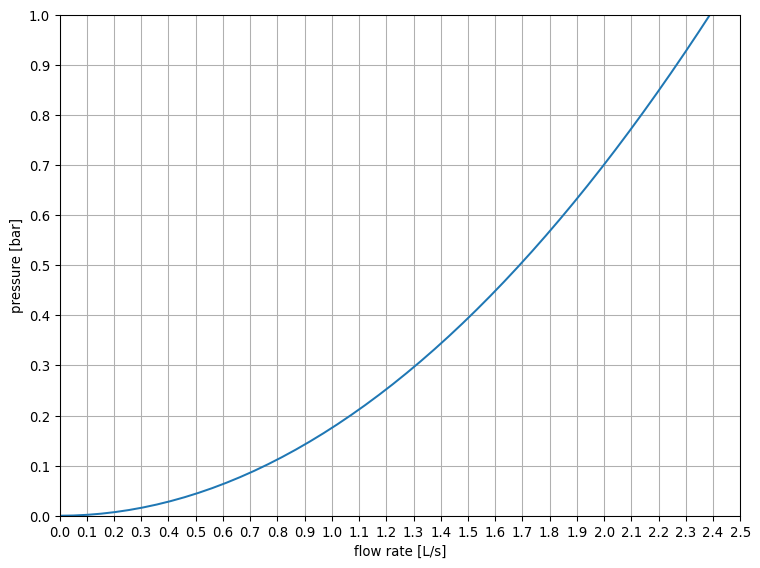

In [23]:
from pypeflow.utils import SystemCurve

sys_curve = SystemCurve(
    R, 
    src_units={'flow_rate': 'm^3/s', 'pressure': 'Pa'}, 
    dest_units={'flow_rate': 'L/s', 'pressure': 'bar'}
)

graph = sys_curve.draw_system_curve(
    V_initial=qty.VolumeFlowRate(0.0, 'L/s'),
    V_final=qty.VolumeFlowRate(2.5, 'L/s'),
    V_max=qty.VolumeFlowRate(2.5, 'L/s'),
    V_step=qty.VolumeFlowRate(0.1, 'L/s'),
    p_max=qty.Pressure(1, 'bar'),
    p_step=qty.Pressure(0.1, 'bar'),
    fig_size=(8, 6)
)
graph.show()